In [64]:
#!conda install yfinance -y
!conda install -c conda-forge statsmodels -y


Channels:
 - conda-forge
 - defaults
 - numba
 - rapidsai
 - nvidia
 - fastai
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/sistemas/miniconda3/envs/diplo

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-1.0.1                |     pyhd8ed1ab_1         182 KB  conda-forge
    statsmodels-0.14.4         |   py39hf3d9206_0        10.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        10.5 MB

The following NEW packages will be INSTALLED:

  patsy              conda-forge/noarch::patsy-1.0.1-pyhd8ed1ab_1 
  statsmodels        conda-forge/linux-64::statsmodels-0.14.4-py39hf3d9206_0 



statsmodels-0.14.4   | 10.4 MB   |                                       |   0% 
statsmodels-0.14.4   | 10.4 MB   |        

In [127]:
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
import numpy as np
import fastai.tabular.all as ft
import torch
from statsmodels.tsa.seasonal import seasonal_decompose
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import os

# etl

In [10]:
p = "/home/sistemas/m/octavo/dataset"

In [11]:

ticker_symbol = "AAPL"
start_date = "1981-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
df = yf.download(ticker_symbol, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df.shape

(11191, 5)

In [7]:
#df.head(1)
df.columns
#df = df.rename(columns={( 'Close', 'AAPL'): 'Close',( 'Volume', 'AAPL'): 'Volume'})

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [8]:
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [9]:
df.head(1)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1981-01-02,0.118316,0.119174,0.118316,0.118316,21660800


In [12]:
#df.isna().sum()
df.drop(columns =df.columns[[1,2,3]] ,inplace=True)
df["Close"] = df["Close"].round(4)

In [13]:
df['Close_shifted'] = df['Close'].shift(1)

In [12]:
df.head()

Price,Close,Volume,Close_shifted
Ticker,AAPL,AAPL,
Date,,,
1981-01-02,0.1183,21660800,NaN
1981-01-05,0.1157,35728000,0.1183
1981-01-06,0.1106,45158400,0.1157
1981-01-07,0.1059,55686400,0.1106
1981-01-08,0.1037,39827200,0.1059


In [14]:
df.isna().sum()
df.dropna(inplace=True)

In [15]:
def error_l1(df,colA,colB):
    df = df.iloc[-365:]
    df = df[[colA, colB]].dropna() 
    return np.mean(np.abs(df[colA].values-df[colB].values))
def error_rmse(df,colA,colB):
    df = df.iloc[-365:]
    df = df[[colA, colB]].dropna() 
    return np.sqrt(np.mean(np.square(df[colA].values-df[colB].values)))

print(error_l1(df,'Close','Close_shifted'))
print(error_rmse(df,'Close','Close_shifted'))

27.58322990429724
34.08395489304079


In [15]:
"""df['EWMA'] = df['Close'].ewm(alpha=0.8).mean().shift(1)
print(error_l1(df,'Close','EWMA'))
print(error_rmse(df,'Close','EWMA'))
df['EWMA_2'] = df['Close'].ewm(alpha=0.8).mean().shift(2)
print(error_l1(df,'Close','EWMA_2'))
print(error_rmse(df,'Close','EWMA_2'))

df['EWMA_4'] = df['Close'].ewm(alpha=0.8).mean().shift(4)
print(error_l1(df,'Close','EWMA_4'))
print(error_rmse(df,'Close','EWMA_4'))    
 """

"df['EWMA'] = df['Close'].ewm(alpha=0.8).mean().shift(1)\nprint(error_l1(df,'Close','EWMA'))\nprint(error_rmse(df,'Close','EWMA'))\ndf['EWMA_2'] = df['Close'].ewm(alpha=0.8).mean().shift(2)\nprint(error_l1(df,'Close','EWMA_2'))\nprint(error_rmse(df,'Close','EWMA_2'))\n\ndf['EWMA_4'] = df['Close'].ewm(alpha=0.8).mean().shift(4)\nprint(error_l1(df,'Close','EWMA_4'))\nprint(error_rmse(df,'Close','EWMA_4'))    \n "

In [16]:
df['Log_Returns_Daily'] = np.log(df['Close'] / df['Close'].shift(1)).round(4)
df['Log_Returns_7D'] = np.log(df['Close'] / df['Close'].shift(7)).round(4)

# Calculate monthly returns and merge in one step
df['Log_Returns_Monthly'] = np.log(df['Close'] / df['Close'].shift(1)).resample('M').last().round(4)

# Forward fill to get monthly returns on daily data
df['Log_Returns_Monthly'] = df['Log_Returns_Monthly'].ffill().round(4)

# Quarterly Log Returns (using end-of-quarter prices)
df['Log_Returns_Quarterly'] = np.log(df['Close'] / df['Close'].shift(1)).resample('Q').last().round(4)

# Forward fill to get monthly returns on daily data
df['Log_Returns_Quarterly'] = df['Log_Returns_Quarterly'].ffill().round(4)

# Rolling Volatility (annualized) for different windows based on daily returns
df['Vol_Daily_7D_Window'] = df['Log_Returns_Daily'].rolling(window=7).std() * np.sqrt(252).round(4)
df['Vol_Daily_21D_Window'] = df['Log_Returns_Daily'].rolling(window=21).std() * np.sqrt(252).round(4)
df['Vol_Daily_63D_Window'] = df['Log_Returns_Daily'].rolling(window=63).std() * np.sqrt(252).round(4)

# Rolling Skewness and Kurtosis of daily log returns
df['Skew_Daily_21D_Window'] = df['Log_Returns_Daily'].rolling(window=21).apply(lambda x: skew(x.dropna()), raw=False).round(4)
df['Kurt_Daily_21D_Window'] = df['Log_Returns_Daily'].rolling(window=21).apply(lambda x: kurtosis(x.dropna()), raw=False).round(4)

# Chande Momentum Oscillator (CMO)
#df['CMO_14'] = tam.chande_momentum_oscillator(close=df['Close'], window=14)

# Average Directional Index (ADX)
#df['ADX_14'] = tat.adx(high=df['High'], low=df['Low'], close=df['Close'], window=14)

# On-Balance Volume (OBV)
#df['OBV'] = tav.on_balance_volume(close=df['Close'], volume=df['Volume'])





In [18]:
df.dropna(inplace=True)
df.head()

Price,Close,Volume,Close_shifted,Log_Returns_Daily,Log_Returns_7D,Log_Returns_Monthly,Log_Returns_Quarterly,Vol_Daily_7D_Window,Vol_Daily_21D_Window,Vol_Daily_63D_Window,Skew_Daily_21D_Window,Kurt_Daily_21D_Window
Ticker,AAPL,AAPL,,,,,,,,,,
Date,,,,,,,,,,,,
1981-04-03,0.0909,16486400,0.0905,0.0044,0.0144,-0.0107,-0.0107,0.609408,0.619878,0.557345,0.1750,-0.1163
1981-04-06,0.0892,22803200,0.0909,-0.0189,0.0147,-0.0107,-0.0107,0.608971,0.622844,0.551897,0.2031,-0.1585
1981-04-07,0.0883,10684800,0.0892,-0.0101,0.0393,-0.0107,-0.0107,0.562688,0.548243,0.546078,0.6896,-0.3163
1981-04-08,0.0926,21952000,0.0883,0.0475,0.0868,-0.0107,-0.0107,0.612779,0.533485,0.553971,0.6311,-0.6302
1981-04-09,0.0943,12499200,0.0926,0.0182,0.1157,-0.0107,-0.0107,0.591205,0.504388,0.544431,0.6606,-0.5950


In [ ]:
#df_clean = df.iloc[63:].copy()

In [ ]:
#df_clean.isna().sum()

Price                  Ticker
Close                  AAPL      0
Volume                 AAPL      0
Close_shifted                    0
Log_Returns_Daily                0
Log_Returns_7D                   0
Log_Returns_Monthly              0
Log_Returns_Quarterly            0
Vol_Daily_7D_Window              0
Vol_Daily_21D_Window             0
Vol_Daily_63D_Window             0
Skew_Daily_21D_Window            0
Kurt_Daily_21D_Window            0
dtype: int64

In [19]:
df.to_csv(f"{p}/apple.csv", index=True)

In [20]:
df.isna().sum()

Price                  Ticker
Close                  AAPL      0
Volume                 AAPL      0
Close_shifted                    0
Log_Returns_Daily                0
Log_Returns_7D                   0
Log_Returns_Monthly              0
Log_Returns_Quarterly            0
Vol_Daily_7D_Window              0
Vol_Daily_21D_Window             0
Vol_Daily_63D_Window             0
Skew_Daily_21D_Window            0
Kurt_Daily_21D_Window            0
dtype: int64

In [ ]:
df.head()

Price,Close,Volume,Close_shifted,Log_Returns_Daily,Log_Returns_7D,Log_Returns_Monthly,Log_Returns_Quarterly,Vol_Daily_7D_Window,Vol_Daily_21D_Window,Vol_Daily_63D_Window,Skew_Daily_21D_Window,Kurt_Daily_21D_Window
Ticker,AAPL,AAPL,,,,,,,,,,
Date,,,,,,,,,,,,
1981-01-05,0.1157,35728000,0.1183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-06,0.1106,45158400,0.1157,-0.0451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-07,0.1059,55686400,0.1106,-0.0434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-08,0.1037,39827200,0.1059,-0.0210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-09,0.1093,21504000,0.1037,0.0526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# nn

In [ ]:
def rmse_loss(yp,y):
    return torch.sqrt(F.mse_loss(yp,y))
def cargar_datos(df):
    n = len(df)
    v = n-1200
    src = ft.TabularPandas(df,
                     cont_names = ['Close_shifted', 'Log_Returns_Daily', 'Log_Returns_7D',
                                   'Log_Returns_Monthly', 'Log_Returns_Quarterly',
                                   'Vol_Daily_7D_Window', 'Vol_Daily_21D_Window',
                                   'Vol_Daily_63D_Window', 'Skew_Daily_21D_Window',
                                   'Kurt_Daily_21D_Window'],
                     
                     y_names = 'Close',
                     splits = (list(range(v)),list(range(v,n)))
                          )
    return src.dataloaders(bs = 500)

### nn0

SuggestedLRs(valley=0.05754399299621582)


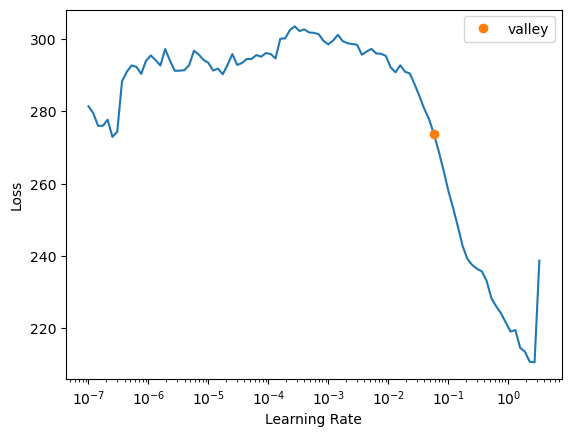

In [146]:
dls = cargar_datos(df)
x_cat, x_cont, y =dls.one_batch()
learn0=ft.tabular_learner(dls,layers=[128],metrics=[F.l1_loss,rmse_loss],opt_func=ft.ranger).to_fp16()
lr =learn0.lr_find()
print(lr)

In [147]:
learn0.fit_one_cycle(100, 0.01)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,296.813232,27718.523438,162.787338,163.959015,00:00
1,286.308716,26967.052734,160.571228,161.717728,00:00
2,290.629822,26497.250000,159.169266,160.301147,00:00
3,286.244293,25794.078125,157.048904,158.160995,00:00
4,282.695465,25097.796875,154.919525,156.011414,00:00
5,270.470551,23485.458984,149.873795,150.916840,00:00
6,255.180435,21127.453125,142.169983,143.143005,00:00
7,236.379364,17473.099609,129.320404,130.180862,00:00
8,206.676575,12033.268555,107.338722,108.033356,00:00
9,171.568222,6262.182617,77.427368,77.929939,00:00


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

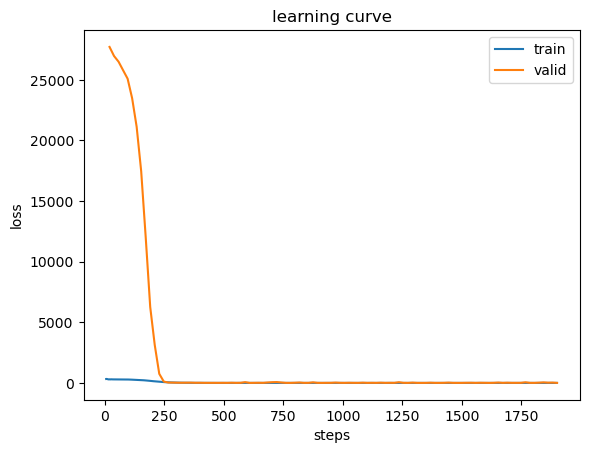

In [148]:
learn0.recorder.plot_loss() 

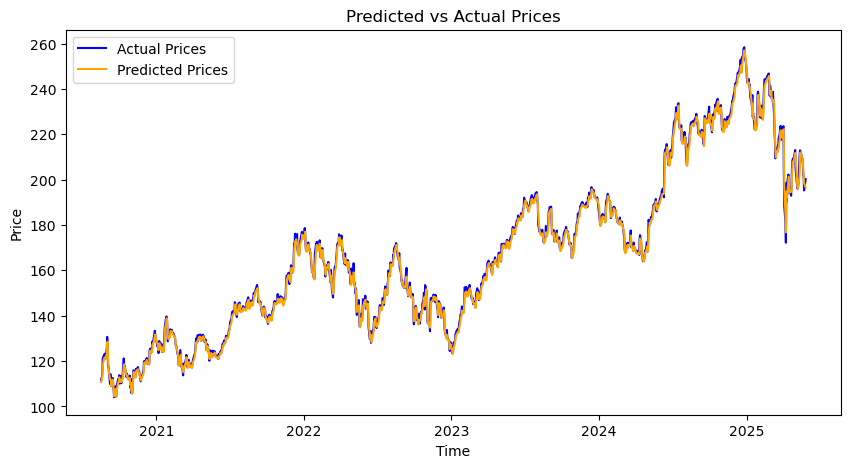

In [149]:
preds0, targs0 = learn1.get_preds()
plt.figure(figsize=(10, 5))
plt.plot(df.index[-1200:],targs0.numpy(), label='Actual Prices', color='blue')
plt.plot(df.index[-1200:],preds0.numpy(), label='Predicted Prices', color='orange')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.show()

In [150]:
learn0.summary()

TabularModel (Input shape: 500 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     500 x 10            
BatchNorm1d                               20         True      
____________________________________________________________________________
                     500 x 128           
Linear                                    1280       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     500 x 1             
Linear                                    129        True      
____________________________________________________________________________

Total params: 1,685
Total trainable params: 1,685
Total non-trainable params: 0

Optimizer used: <function ranger at 0x7fc64741f1f0>
Loss function: FlattenedLoss of MSELoss()

Model unfrozen

Callbacks:
  - TrainEvalCallba

In [151]:
learn0.export(f"{p}/apple_model.pkl")

# nn 1


In [ ]:
def rmse_loss(yp,y):
    return torch.sqrt(F.mse_loss(yp,y))

In [ ]:
#df_clean = pd.read_csv(f"{p}/apple.csv", index_col=0, parse_dates=True)

/tmp/ipykernel_3702/868457166.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean = pd.read_csv(f"{p}/apple.csv", index_col=0, parse_dates=True)


SuggestedLRs(valley=0.033113110810518265)


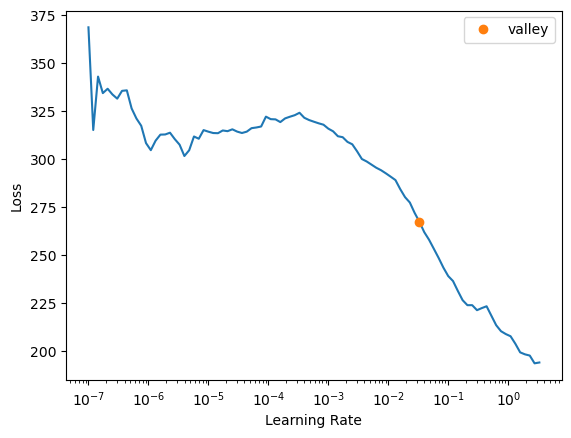

In [ ]:
dls = cargar_datos(df)
x_cat, x_cont, y =dls.one_batch()
learn1=ft.tabular_learner(dls,layers=[128,200,300,200,100],metrics=[F.l1_loss,rmse_loss],opt_func=ft.ranger).to_fp16()
lr =learn1.lr_find()
print(lr)
learn1.fit_one_cycle(100, 0.033)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,248.324860,26489.732422,159.118561,160.273911,00:00
1,215.826828,15649.096680,122.275505,123.165237,00:00
2,191.041946,9971.615234,97.596588,98.323761,00:00
3,162.163162,5011.668457,69.197029,69.715332,00:00
4,138.596466,5146.096191,70.066017,70.616814,00:00
5,112.881439,2071.077393,44.387344,44.787945,00:00
6,89.309578,213.172089,13.975361,14.321506,00:00
7,68.635063,1395.136963,36.138756,36.603825,00:00
8,52.089458,2624.150879,49.853653,50.419449,00:00
9,37.765793,3192.297607,55.014278,55.506947,00:00


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

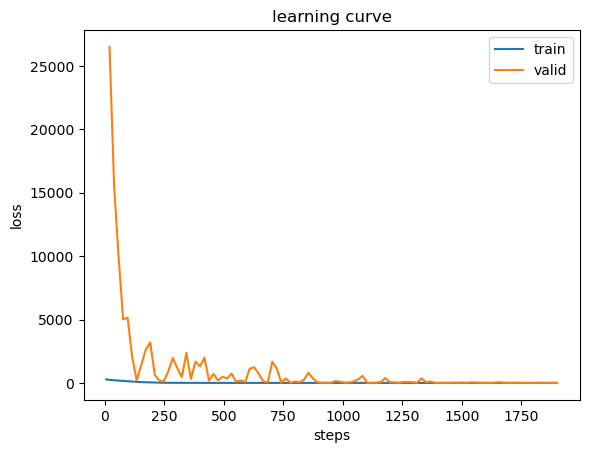

In [131]:
learn1.recorder.plot_loss()  # Loss en train/valid

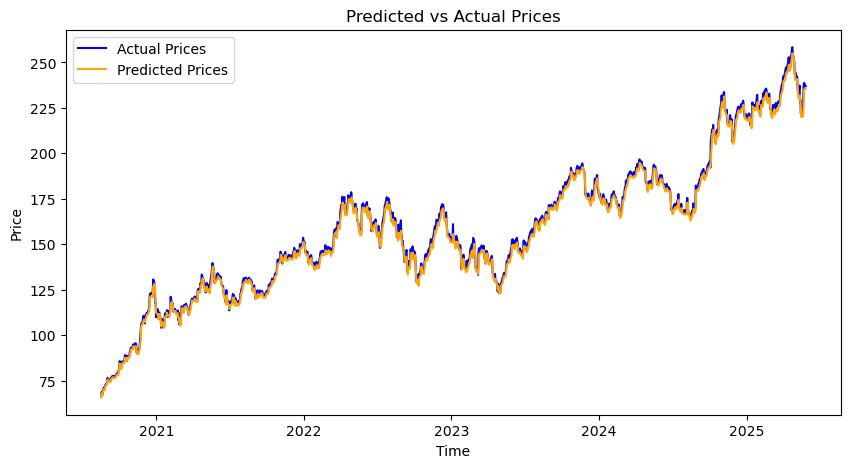

In [132]:
preds1, targs1 = learn1.get_preds()
plt.figure(figsize=(10, 5))
plt.plot(df.index[-1200:],targs.numpy(), label='Actual Prices', color='blue')
plt.plot(df.index[-1200:],preds.numpy(), label='Predicted Prices', color='orange')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.show()

# nn2

### etl

In [133]:
d2 = df.copy()

In [134]:
result = seasonal_decompose(df['Close'],period=160)
d2['Trend'] = result.trend
d2['Seasonal'] = result.seasonal
d2['Residual'] = result.resid

In [135]:
d2.columns

MultiIndex([(                'Close', 'AAPL'),
            (               'Volume', 'AAPL'),
            (        'Close_shifted',     ''),
            (    'Log_Returns_Daily',     ''),
            (       'Log_Returns_7D',     ''),
            (  'Log_Returns_Monthly',     ''),
            ('Log_Returns_Quarterly',     ''),
            (  'Vol_Daily_7D_Window',     ''),
            ( 'Vol_Daily_21D_Window',     ''),
            ( 'Vol_Daily_63D_Window',     ''),
            ('Skew_Daily_21D_Window',     ''),
            ('Kurt_Daily_21D_Window',     ''),
            (                'Trend',     ''),
            (             'Seasonal',     ''),
            (             'Residual',     '')],
           names=['Price', 'Ticker'])

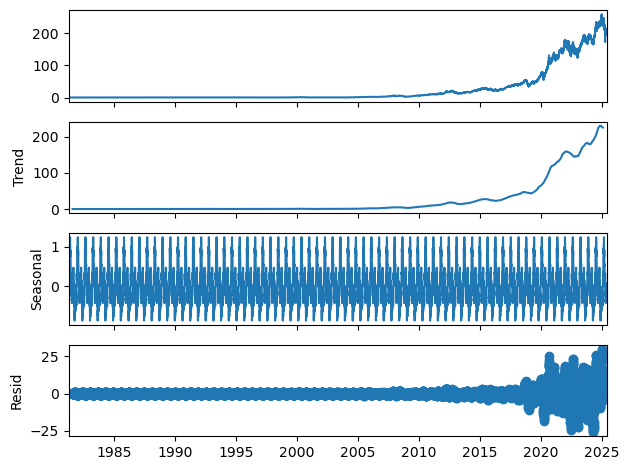

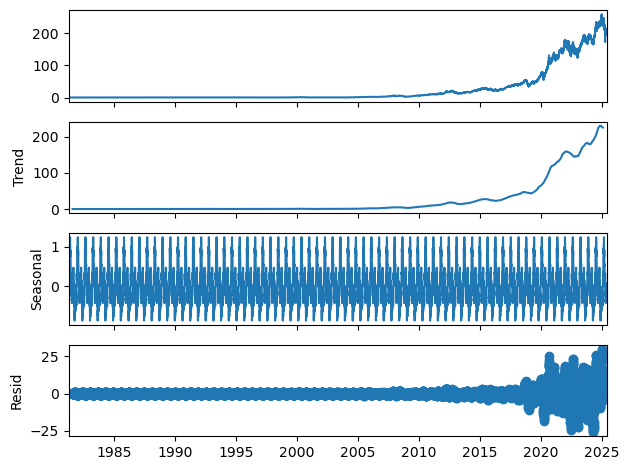

In [136]:
result.plot()

In [137]:
d2.dropna(inplace=True)

### nn2

SuggestedLRs(valley=0.015848932787775993)


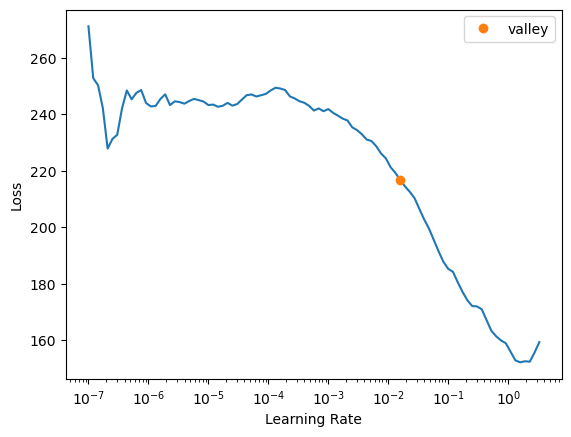

In [138]:
dls2 = cargar_datos(d2)
learn=ft.tabular_learner(dls2,lr=0.01, layers=[128,200,300,200,100],metrics=[F.l1_loss,rmse_loss],opt_func=ft.ranger).to_fp16()
lr =learn.lr_find()
print(lr)

In [139]:
learn.fit_one_cycle(100, 0.033)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,193.888504,24370.619141,151.708481,153.362289,00:00
1,168.899124,12736.253906,109.610420,110.819000,00:00
2,146.157669,5300.595703,70.723831,71.507515,00:00
3,125.725151,2307.118652,46.712025,47.212940,00:00
4,105.901985,2798.635742,51.384525,51.957680,00:00
5,87.835373,693.063843,25.642262,25.915676,00:00
6,70.131531,222.437286,13.937707,14.415599,00:00
7,55.170223,205.768509,13.692967,14.112523,00:00
8,41.371872,684.364380,25.154980,25.645025,00:00
9,29.435339,1372.484619,35.924984,36.435307,00:00


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

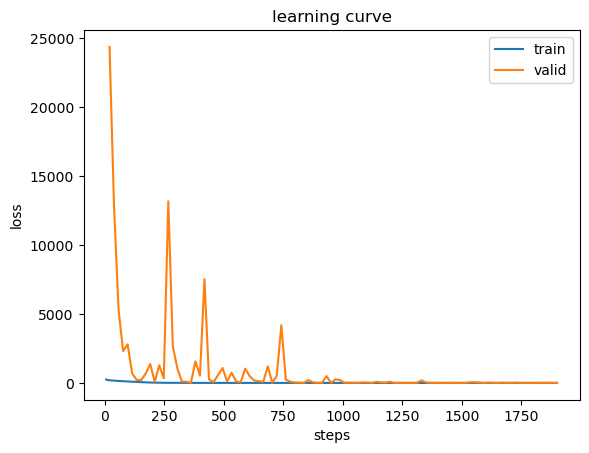

In [140]:
learn.recorder.plot_loss() 

In [141]:
learn.summary()

TabularModel (Input shape: 500 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     500 x 10            
BatchNorm1d                               20         True      
____________________________________________________________________________
                     500 x 128           
Linear                                    1280       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     500 x 200           
Linear                                    25600      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     500 x 300           
Linear                                    60000      

In [142]:
learn.validate()

(#3) [6.768905162811279,2.1370797157287598,2.5507466793060303]

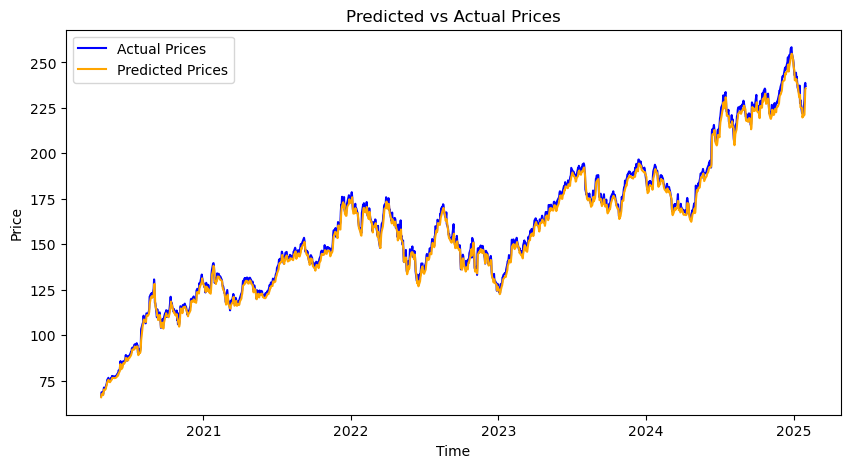

In [ ]:
preds, targs = learn.get_preds()
plt.figure(figsize=(10, 5))
plt.plot(d2.index[-1200:],targs.numpy(), label='Actual Prices', color='blue')
plt.plot(d2.index[-1200:],preds.numpy(), label='Predicted Prices', color='orange')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.show()
#print(type(d3))
#d3.plot(figsize=(10, 5), title='Predicted vs Actual Prices', xlabel='Date', ylabel='Price')
#d3 = d3.set_index('Date')
#d3.Close



In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11127 entries, 1981-04-03 to 2025-05-27
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   (Close, AAPL)              11127 non-null  float64
 1   (Volume, AAPL)             11127 non-null  int64  
 2   (Close_shifted, )          11127 non-null  float64
 3   (Log_Returns_Daily, )      11127 non-null  float64
 4   (Log_Returns_7D, )         11127 non-null  float64
 5   (Log_Returns_Monthly, )    11127 non-null  float64
 6   (Log_Returns_Quarterly, )  11127 non-null  float64
 7   (Vol_Daily_7D_Window, )    11127 non-null  float64
 8   (Vol_Daily_21D_Window, )   11127 non-null  float64
 9   (Vol_Daily_63D_Window, )   11127 non-null  float64
 10  (Skew_Daily_21D_Window, )  11127 non-null  float64
 11  (Kurt_Daily_21D_Window, )  11127 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.1 MB


In [153]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10967 entries, 1981-07-29 to 2025-01-30
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   (Close, AAPL)              10967 non-null  float64
 1   (Volume, AAPL)             10967 non-null  int64  
 2   (Close_shifted, )          10967 non-null  float64
 3   (Log_Returns_Daily, )      10967 non-null  float64
 4   (Log_Returns_7D, )         10967 non-null  float64
 5   (Log_Returns_Monthly, )    10967 non-null  float64
 6   (Log_Returns_Quarterly, )  10967 non-null  float64
 7   (Vol_Daily_7D_Window, )    10967 non-null  float64
 8   (Vol_Daily_21D_Window, )   10967 non-null  float64
 9   (Vol_Daily_63D_Window, )   10967 non-null  float64
 10  (Skew_Daily_21D_Window, )  10967 non-null  float64
 11  (Kurt_Daily_21D_Window, )  10967 non-null  float64
 12  (Trend, )                  10967 non-null  float64
 13  (Seasonal, )               10

# nnz

In [155]:
def cargar_datos(df):
    n = len(df)
    v = n-1200
    src = ft.TabularPandas(df,
                     cont_names = ['Close_shifted'],
                     
                     y_names = 'Close',
                     splits = (list(range(v)),list(range(v,n)))
                          )
    return src.dataloaders(bs = 500)

In [156]:
dfz = df[['Close_shifted', 'Close']].copy()

SuggestedLRs(valley=0.007585775572806597)


epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,174.514450,15767.875000,122.813683,123.699089,00:00
1,144.061508,12398.792969,108.855362,109.661278,00:00
2,135.017426,9903.007812,97.214142,97.962410,00:00
3,119.085899,6767.680664,80.285179,80.939224,00:00
4,104.110588,3856.673340,60.533592,61.069641,00:00
5,89.317078,2195.944092,45.613228,46.063644,00:00
6,74.327789,681.519470,25.349268,25.696510,00:00
7,60.995167,259.953094,15.601947,15.949255,00:00
8,47.199913,69.947800,7.790311,8.308908,00:00
9,35.683983,64.801186,7.431529,7.973007,00:00


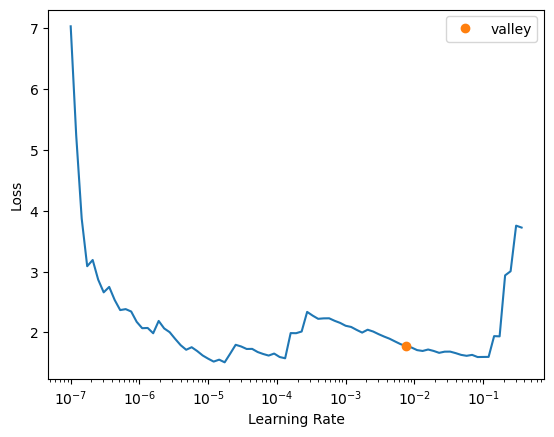

In [161]:
dls = cargar_datos(dfz)
lr =learn1.lr_find()
learn1=ft.tabular_learner(dls,lr=0.01,layers=[128],metrics=[F.l1_loss,rmse_loss],opt_func=ft.ranger).to_fp16()
print(lr)
learn1.fit_one_cycle(100, 0.033)

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

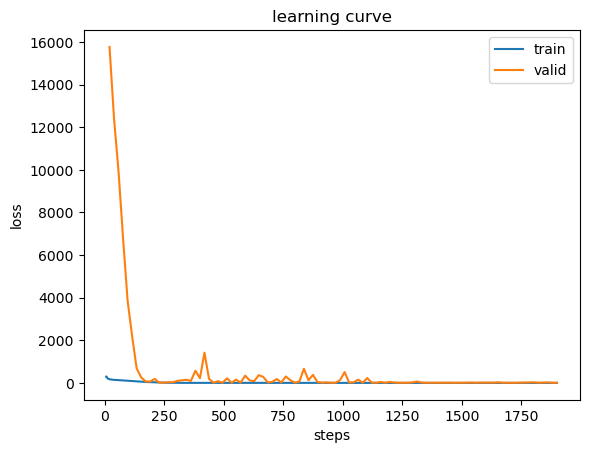

In [162]:
learn1.recorder.plot_loss()  # Loss en train/valid

In [163]:
learn.summary()

TabularModel (Input shape: 500 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     500 x 10            
BatchNorm1d                               20         True      
____________________________________________________________________________
                     500 x 128           
Linear                                    1280       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     500 x 200           
Linear                                    25600      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     500 x 300           
Linear                                    60000      

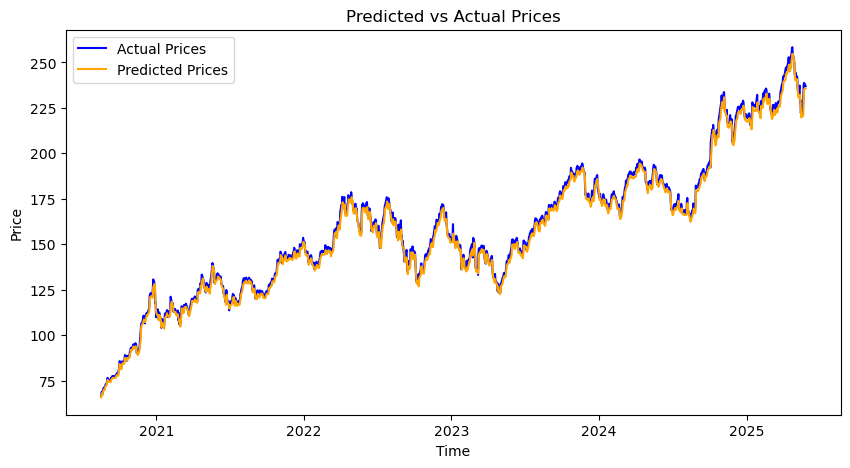

In [164]:
preds1, targs1 = learn1.get_preds()
plt.figure(figsize=(10, 5))
plt.plot(df.index[-1200:],targs.numpy(), label='Actual Prices', color='blue')
plt.plot(df.index[-1200:],preds.numpy(), label='Predicted Prices', color='orange')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.show()